In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats

#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from sklearn.mixture import GaussianMixture 
#import testing
import sys
sys.path.append("../")
import selection_tests

import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
data = pd.read_stata("../data/all_plans_c_stata_2019.dta")

#create a variable that is just db 
treat = data[['ssa', 'double_bonus']].copy()
treat = treat.groupby(['ssa'],as_index=False).max()
treat = treat.rename(columns={'double_bonus':'treatment' })


print(treat)
print(data.shape)
data = data.merge(treat, on=['ssa'],how='left')

        ssa  treatment
0      1000          1
1      1010          1
2      1020          0
3      1030          1
4      1040          1
...     ...        ...
2186  53060          0
2187  53120          0
2188  53160          0
2189  53200          0
2190  53220          0

[2191 rows x 2 columns]
(30674, 19)


/tmp/ipykernel_130523/2106469193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff


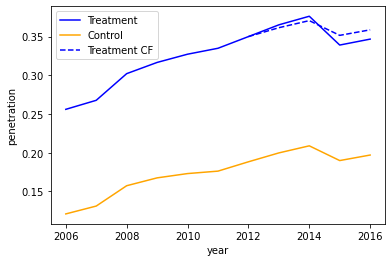

(    year  penetration   enr_total  treatment         y
 0   2006   131.870850  23728822.0          0  0.120856
 1   2007   162.237015  24006278.0          0  0.131017
 2   2008   225.589874  24360788.0          0  0.157292
 3   2009   243.649323  24702544.0          0  0.167442
 4   2010   253.080093  25245280.0          0  0.172996
 5   2011   248.878082  25710872.0          0  0.176151
 6   2012   266.071014  26675474.0          0  0.188204
 7   2013   286.231995  27418118.0          0  0.199692
 8   2014   297.617279  27911378.0          0  0.208847
 9   2015   263.420807  32984912.0          0  0.189800
 10  2016   273.677063  33754808.0          0  0.196950,
     year  penetration   enr_total         y
 0   2006    59.585571   7417512.0  0.256009
 1   2007    64.282379   7535679.0  0.267676
 2   2008    75.673065   7488031.0  0.302124
 3   2009    80.482384   7564414.0  0.316614
 4   2010    83.504379   7709438.0  0.327253
 5   2011    85.226562   7879745.0  0.334914
 6   2012   

In [16]:
def create_plot_y(df):
    df = df.copy()
    df['y'] = df['penetration']*df['enr_total']
    df_group = df.groupby('year',as_index=False).sum()
    df_group['y'] = df_group['y']/df_group['enr_total']
    return df_group.copy()


def create_synth_plot(data,intervention,begin,end,name):    
    #treatment
    data_treat = data[(data['treatment']==1) & (data['year'] >= begin) &
                              (data['year'] <= end) ][['penetration','year','enr_total']]
    data_treat =  create_plot_y(data_treat)
    plt.plot(data_treat['year'],data_treat['y'],label='Treatment',color='blue')

    
    #control
    data_control  = data[ (data['treatment']==0) & (data['year'] >= begin) &
                              (data['year'] <= end) ][['penetration','year','enr_total','treatment']]
    data_control =  create_plot_y(data_control)
    plt.plot(data_control['year'],data_control['y'],label='Control',color='orange')
    

    #treat cf
    data_treat_cf = data_control[ (data_control['year']>=intervention) & (data_control['year']<=end)]
    diff = (data_treat['y'][data_treat['year']==intervention].mean() - 
                data_control['y'][data_control['year']==intervention].mean())
    data_treat_cf['y'] = data_treat_cf['y'] + diff
    
        
    plt.plot(data_treat_cf['year'],data_treat_cf['y'],label='Treatment CF',color='blue',linestyle='--')

    plt.xlabel('year')
    plt.ylabel('penetration')
    plt.legend()
    plt.savefig(name,dpi=300)
    plt.show()
    return data_control, data_treat, data_treat_cf
    
create_synth_plot(data,2012,2006,2016,'double_bonus_intervention.png')

/tmp/ipykernel_130523/2106469193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff


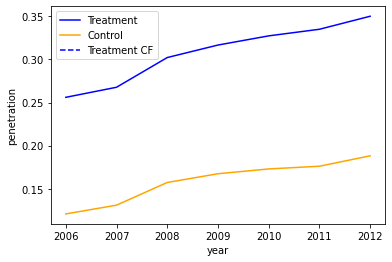

(   year  penetration   enr_total  treatment         y
 0  2006   131.870850  23728822.0          0  0.120856
 1  2007   162.237015  24006278.0          0  0.131017
 2  2008   225.589874  24360788.0          0  0.157292
 3  2009   243.649323  24702544.0          0  0.167442
 4  2010   253.080093  25245280.0          0  0.172996
 5  2011   248.878082  25710872.0          0  0.176151
 6  2012   266.071014  26675474.0          0  0.188204,
    year  penetration  enr_total         y
 0  2006    59.585571  7417512.0  0.256009
 1  2007    64.282379  7535679.0  0.267676
 2  2008    75.673065  7488031.0  0.302124
 3  2009    80.482384  7564414.0  0.316614
 4  2010    83.504379  7709438.0  0.327253
 5  2011    85.226562  7879745.0  0.334914
 6  2012    89.060013  8240389.0  0.350004,
    year  penetration   enr_total  treatment         y
 6  2012   266.071014  26675474.0          0  0.350004)

In [17]:
create_synth_plot(data,2012,2006,2012,'double_bonus_intervention-zoom.png')

In [6]:
print(data['bm_ns'].mean())
print(data['bmFFS'].mean())
print(data['bmFFS_ns_diff'].mean())
print(data['bm_ns']-data['bmFFS'])

898.3458862304688
912.5452880859375
14.198017120361328
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
30669    0.0
30670    0.0
30671    0.0
30672    0.0
30673    0.0
Length: 30674, dtype: float32


In [18]:
cutoff1 = 10
cutoff2 = 3

#make a new treatment var...
data_bm = data.copy()
data_bm = data_bm.drop(['treatment','bm_ns_2012'],axis=1)

treat = data[['ssa','bm_ns']].copy()
treat_2011 = data[['ssa', 'bm_ns']][data['year']==2011]
treat_2011 = treat_2011.groupby(['ssa'],as_index=False).max()

treat_2012 = data[['ssa', 'bm_ns']][data['year']==2012]
treat_2012 = treat_2012.groupby(['ssa'],as_index=False).max()


treat_2012_2 = data[['ssa', 'bmFFS']][data['year']==2012]
treat_2012_2 = treat_2012_2.groupby(['ssa'],as_index=False).max()

treat = treat_2011.merge(treat_2012,on=['ssa'],suffixes=('_2011', '_2012'))
treat = treat.merge(treat_2012_2,on=['ssa'])




print(data_bm.shape)
data_bm = data_bm.merge(treat, on=['ssa'],how='left',suffixes=('','_2012'))
print(data_bm.shape)

data_bm['treatment_1'] = 100*(data_bm['bm_ns_2011'] - data_bm['bm_ns_2012'])/data_bm['bm_ns_2011'] 
data_bm['treatment_2'] = 100*(data_bm['bmFFS_2012'] - data_bm['bm_ns_2012'])/data_bm['bm_ns_2012'] 
data_bm['treatment'] =  (data_bm['treatment_1'] > cutoff1 )*(data_bm['treatment_2'] < cutoff2)
#data_bm['treatment_1']  + 2 >= data_bm['treatment_2'] 
print(data_bm[['bm_ns_2011','bm_ns_2012','bmFFS_2012','treatment_1','treatment_2','treatment']])

#bm 5_star with some percent of bm cut

(30674, 18)
(30674, 21)
       bm_ns_2011  bm_ns_2012  bmFFS_2012  treatment_1  treatment_2  treatment
0      952.801208  888.654602  904.911377     6.732423     1.829369      False
1      952.801208  888.654602  904.911377     6.732423     1.829369      False
2      952.801208  888.654602  904.911377     6.732423     1.829369      False
3      952.801208  888.654602  904.911377     6.732423     1.829369      False
4      952.801208  888.654602  904.911377     6.732423     1.829369      False
...           ...         ...         ...          ...          ...        ...
30669  863.120728  829.804260  853.839294     3.860001     2.896470      False
30670  863.120728  829.804260  853.839294     3.860001     2.896470      False
30671  863.120728  829.804260  853.839294     3.860001     2.896470      False
30672  863.120728  829.804260  853.839294     3.860001     2.896470      False
30673  863.120728  829.804260  853.839294     3.860001     2.896470      False

[30674 rows x 6 columns]


/tmp/ipykernel_130523/2106469193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat_cf['y'] = data_treat_cf['y'] + diff


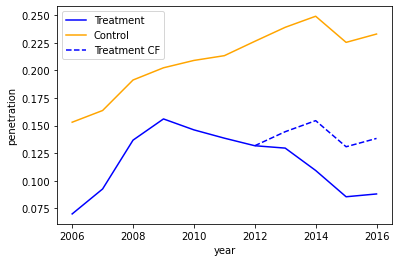

0     0.069917
1     0.092539
2     0.136833
3     0.156061
4     0.146140
5     0.138616
6     0.131758
7     0.129600
8     0.109313
9     0.085476
10    0.088020
Name: y, dtype: float32


In [19]:
data_control, data_treat, data_treat_cf = create_synth_plot(data_bm,2012,2006,2016,'bm_cuts_intervention.png')

print(data_treat['y'])